# House Prices Prediction 

## Importing the libraries

In [20]:
# Data structures
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

## Loading the labeled dataset


In [21]:
# Load the data
dataset_df = pd.read_csv("train.csv")
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


## Preprocessing of the dataset

In [22]:
total_null = dataset_df.isnull().sum()
total_null = total_null[total_null > 0].sort_values(ascending=False)
print(total_null)

# Dropping Outliers
ids_to_drop = [1183, 692, 198, 1170, 1299, 186, 770, 636]
dataset_df = dataset_df[~dataset_df['Id'].isin(ids_to_drop)]

# Dropping Id + features weakly correlated with SalePrice
dataset_df = dataset_df.drop(['Id','BsmtFinSF2','MiscVal'],axis=1)
# Dropping features that have strong correlation with other features
dataset_df = dataset_df.drop(['GarageYrBlt', 'GarageCars', 'TotRmsAbvGrd', 'GrLivArea'], axis=1)
# Dropping features that have high counts of Missing Values
    # MasVnrArea was included in this drop statement since it is related to MasVnrType and likely has a similar amount of predictive significance
dataset_df = dataset_df.drop(['PoolQC', 'MiscFeature','Alley', 'Fence', 'MasVnrType', 'MasVnrArea', 'FireplaceQu', 'LotFrontage'], axis=1)

#Reassigning remaining null values
dataset_df.loc[:, 'BsmtQual'] = dataset_df['BsmtQual'].fillna('No')
dataset_df.loc[:, 'BsmtCond'] = dataset_df['BsmtCond'].fillna('No')
dataset_df.loc[:, 'BsmtExposure'] = dataset_df['BsmtExposure'].fillna('NB')
dataset_df.loc[:, 'BsmtFinType1'] = dataset_df['BsmtFinType1'].fillna('NoB')
dataset_df.loc[:, 'BsmtFinType2'] = dataset_df['BsmtFinType2'].fillna('NoB')
dataset_df.loc[:, 'Electrical'] = dataset_df['Electrical'].fillna('NoB')
dataset_df.loc[:, 'GarageType'] = dataset_df['GarageType'].fillna('NoGarge')
dataset_df.loc[:, 'GarageFinish'] = dataset_df['GarageFinish'].fillna('NoG')
dataset_df.loc[:, 'GarageQual'] = dataset_df['GarageQual'].fillna('No')
dataset_df.loc[:, 'GarageCond'] = dataset_df['GarageCond'].fillna('No')
dataset_df.head(3)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,61,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,42,0,0,0,0,9,2008,WD,Normal,223500


In [23]:
total_null = dataset_df.isnull().sum()
total_null = total_null[total_null > 0].sort_values(ascending=False)
print(total_null)


Series([], dtype: int64)


## Preprocessing of the dataset that will be used for the competition

In [24]:
finaltest_df = pd.read_csv("test.csv")
finaltest_df = finaltest_df.drop(['Id'], axis=1)

finaltest_df = finaltest_df.drop(['BsmtFinSF2','MiscVal'],axis=1)
finaltest_df = finaltest_df.drop(['GarageYrBlt', 'GarageCars', 'TotRmsAbvGrd', 'GrLivArea'], axis=1)
finaltest_df = finaltest_df.drop(['PoolQC', 'MiscFeature','Alley', 'Fence', 'MasVnrType', 'MasVnrArea', 'FireplaceQu', 'LotFrontage'], axis=1)

In [25]:

finaltest_df.loc[:, 'BsmtQual'] = finaltest_df['BsmtQual'].fillna('No')
finaltest_df.loc[:, 'BsmtCond'] = finaltest_df['BsmtCond'].fillna('No')
finaltest_df.loc[:, 'BsmtExposure'] = finaltest_df['BsmtExposure'].fillna('NB')
finaltest_df.loc[:, 'BsmtFinType1'] = finaltest_df['BsmtFinType1'].fillna('NoB')
finaltest_df.loc[:, 'BsmtFinType2'] = finaltest_df['BsmtFinType2'].fillna('NoB')
finaltest_df.loc[:, 'Electrical'] = finaltest_df['Electrical'].fillna('NoB')
finaltest_df.loc[:, 'GarageType'] = finaltest_df['GarageType'].fillna('NoGarge')
finaltest_df.loc[:, 'GarageFinish'] = finaltest_df['GarageFinish'].fillna('NoG')
finaltest_df.loc[:, 'GarageQual'] = finaltest_df['GarageQual'].fillna('No')
finaltest_df.loc[:, 'GarageCond'] = finaltest_df['GarageCond'].fillna('No')

# Reassigning remaining null values
finaltest_df.loc[:, 'MSZoning'] = finaltest_df['MSZoning'].fillna('No')
finaltest_df.loc[:, 'Utilities'] = finaltest_df['Utilities'].fillna('No')
finaltest_df.loc[:, 'BsmtFullBath'] = finaltest_df['BsmtFullBath'].fillna(0)
finaltest_df.loc[:, 'BsmtHalfBath'] = finaltest_df['BsmtHalfBath'].fillna(0)
finaltest_df.loc[:, 'Functional'] = finaltest_df['Functional'].fillna('No')
finaltest_df.loc[:, 'Exterior1st'] = finaltest_df['Exterior1st'].fillna('No')
finaltest_df.loc[:, 'Exterior2nd'] = finaltest_df['Exterior2nd'].fillna('No')
finaltest_df.loc[:, 'BsmtFinSF1'] = finaltest_df['BsmtFinSF1'].fillna(0)
finaltest_df.loc[:, 'BsmtUnfSF'] = finaltest_df['BsmtUnfSF'].fillna(0)
finaltest_df.loc[:, 'TotalBsmtSF'] = finaltest_df['TotalBsmtSF'].fillna(0)
finaltest_df.loc[:, 'KitchenQual'] = finaltest_df['KitchenQual'].fillna('No')
finaltest_df.loc[:, 'GarageArea'] = finaltest_df['GarageArea'].fillna(0)
finaltest_df.loc[:, 'SaleType'] = finaltest_df['SaleType'].fillna('No')

total_null = finaltest_df.isnull().sum()
total_null = total_null[total_null > 0].sort_values(ascending=False)
print(total_null)

Series([], dtype: int64)


## Assigning the same "cat" codes for all the object values in order to have the same numerical structure for both the datasets

In [26]:
for column in dataset_df.columns:
    if dataset_df[column].dtype == 'object':
        # Convert the column to 'category' type in dataset_df
        dataset_df[column] = dataset_df[column].astype('category')
        # Get the unique values
        unique_values = dataset_df[column].cat.categories
        
        # Define a CategoricalDtype with the unique values
        cat_dtype = pd.api.types.CategoricalDtype(categories=unique_values, ordered=True)
        
        # Apply the CategoricalDtype to both dataset_df and finaltest_df columns
        dataset_df[column] = dataset_df[column].astype(cat_dtype)
        finaltest_df[column] = finaltest_df[column].astype(cat_dtype)
        
        # Get the codes for dataset_df and finaltest_df
        dataset_codes = dataset_df[column].cat.codes
        finaltest_codes = finaltest_df[column].cat.codes
        
        # Assign the codes back to the DataFrame columns
        dataset_df[column] = dataset_codes
        finaltest_df[column] = finaltest_codes
        

In [27]:
# Calculate the correlation matrix
corr_matrix = dataset_df.corr()

# Sort the correlations for 'SalePrice' in descending order
saleprice_corr = corr_matrix['SalePrice'].sort_values(ascending=False)

# Exclude the 'SalePrice' itself from the important features
important_features = saleprice_corr.index[1:100]

print("Most important features for 'SalePrice':")
print(important_features)


Most important features for 'SalePrice':
Index(['OverallQual', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'YearBuilt',
       'FullBath', 'YearRemodAdd', 'Fireplaces', 'Foundation', 'BsmtFinSF1',
       'OpenPorchSF', 'WoodDeckSF', 'HalfBath', '2ndFlrSF', 'CentralAir',
       'GarageCond', 'LotArea', 'Electrical', 'SaleCondition', 'PavedDrive',
       'BsmtFullBath', 'GarageQual', 'BsmtUnfSF', 'RoofStyle', 'Neighborhood',
       'HouseStyle', 'BedroomAbvGr', 'ExterCond', 'Functional', 'Exterior2nd',
       'Exterior1st', 'Condition1', 'ScreenPorch', 'BsmtCond', 'BsmtFinType2',
       'RoofMatl', 'MoSold', '3SsnPorch', 'LandSlope', 'Street', 'PoolArea',
       'LandContour', 'Condition2', 'Utilities', 'YrSold', 'BsmtHalfBath',
       'LotConfig', 'SaleType', 'LowQualFinSF', 'BldgType', 'OverallCond',
       'MSSubClass', 'BsmtFinType1', 'Heating', 'EnclosedPorch',
       'KitchenAbvGr', 'MSZoning', 'LotShape', 'BsmtExposure', 'HeatingQC',
       'GarageFinish', 'GarageType', 'KitchenQual'

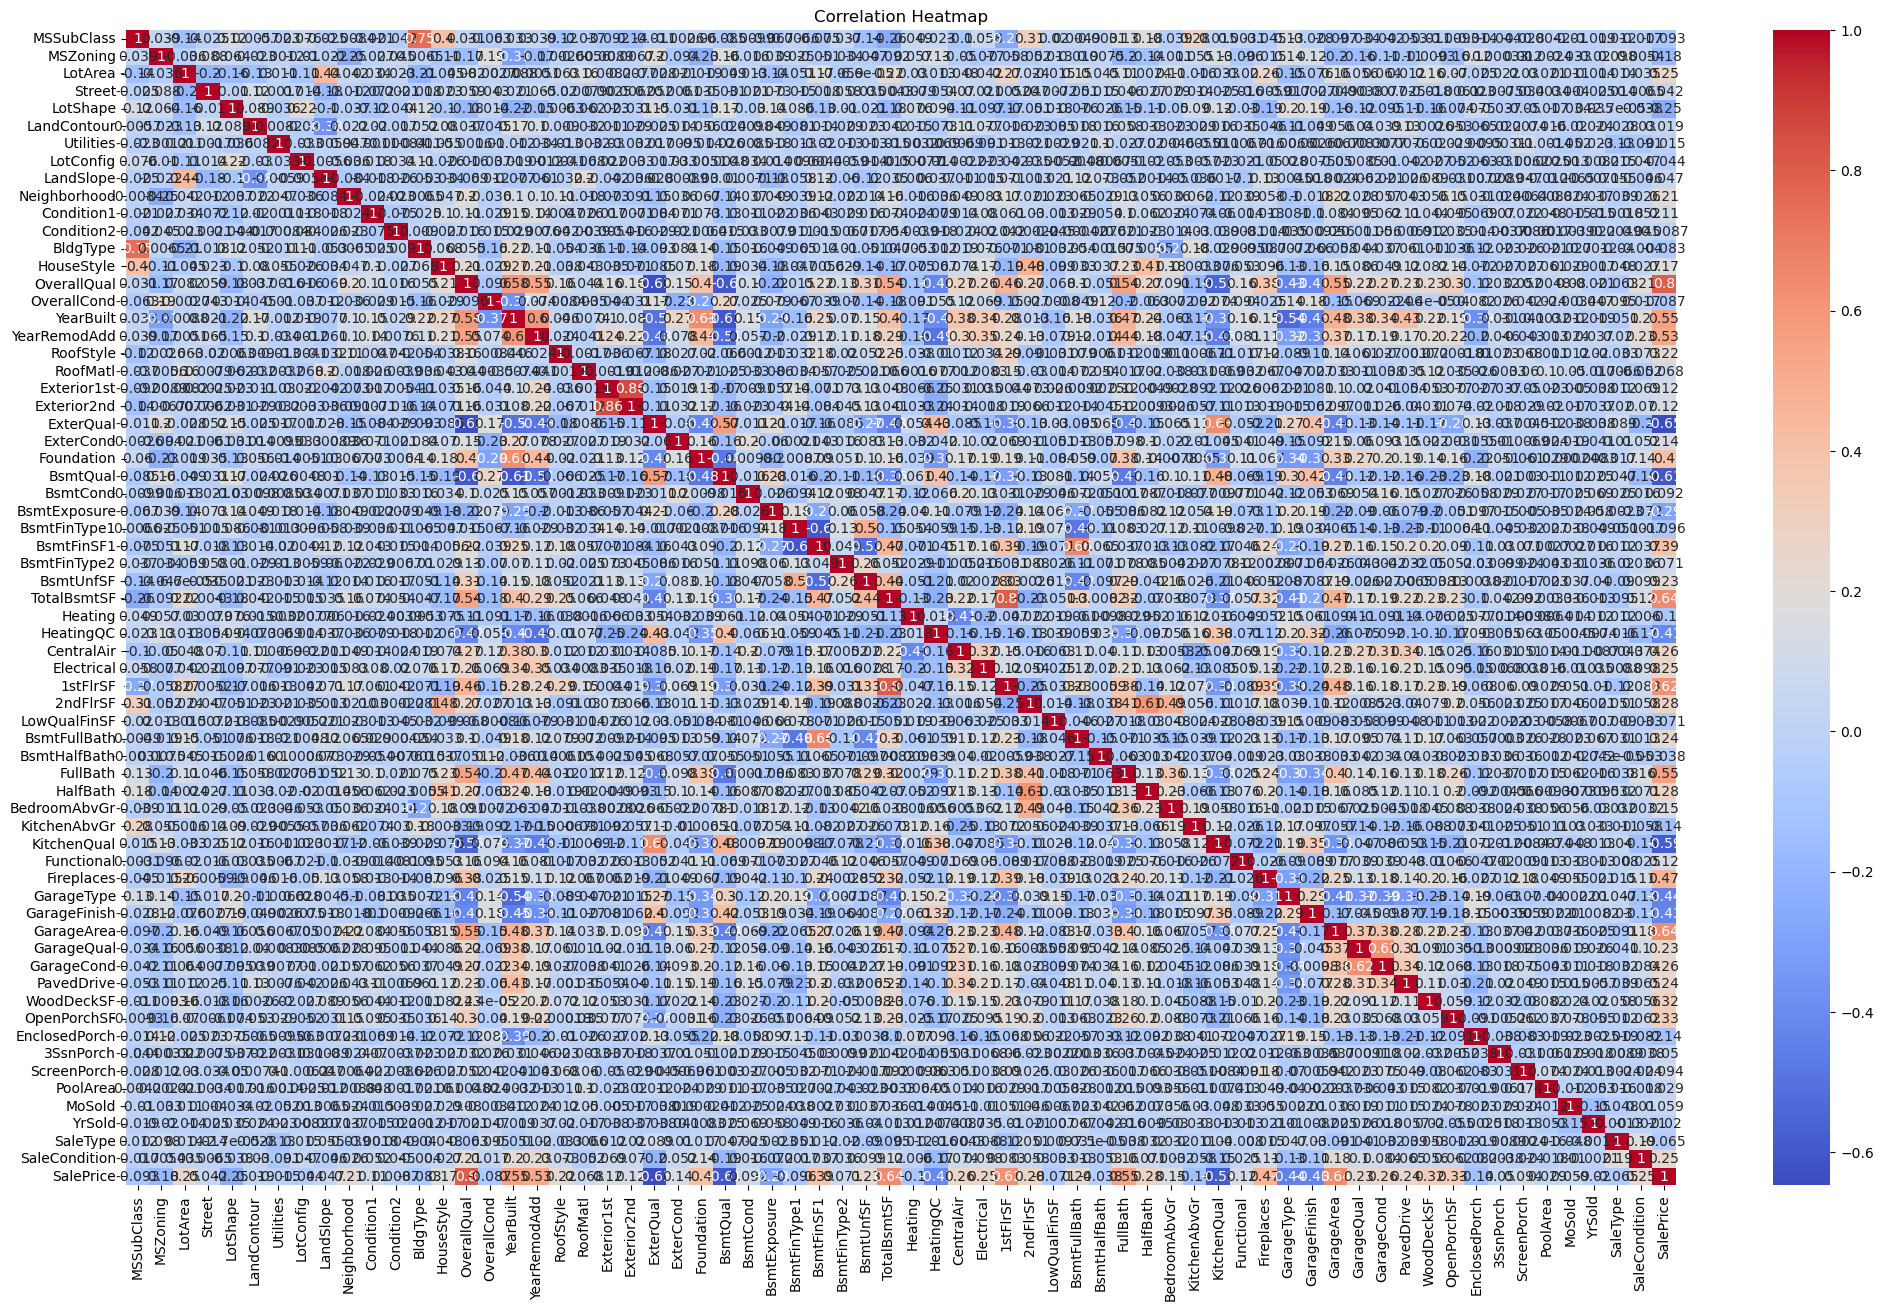

In [28]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a correlation matrix
corr_matrix = dataset_df.corr()

# Create a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Splitting the data into training and testing data

In [29]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (1161, 66)
Testing set shape: (291, 66)


In [30]:
label = 'SalePrice'
x_train = train_df.drop(label, axis=1)
y_train = train_df[label]

x_test = test_df.drop(label, axis=1)
y_test = test_df[label]


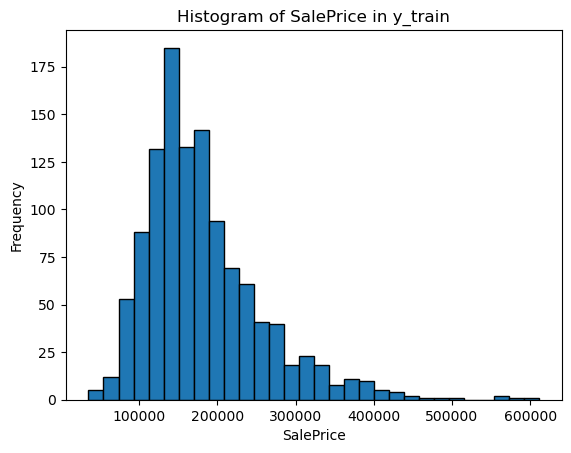

In [31]:
import matplotlib.pyplot as plt

# Plot histogram of SalePrice in y_train
plt.hist(y_train, bins=30, edgecolor='black')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Histogram of SalePrice in y_train')
plt.show()

## We need to apply a log1p to the label in order to center the gaussian

In [32]:
import numpy as np
# Log transform the SalePrice as it is skewed
y_train = np.log1p(y_train)

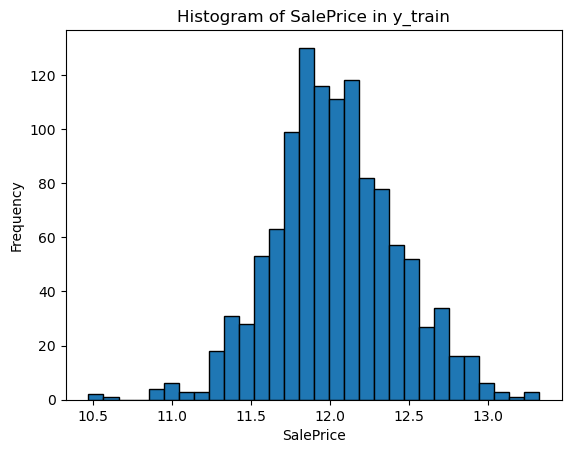

In [33]:
# Plot histogram of SalePrice in y_train
plt.hist(y_train, bins=30, edgecolor='black')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Histogram of SalePrice in y_train')
plt.show()

## Implementing XGBoost model with GridSearchCV 

In [34]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Setup the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(x_train, y_train)
# Find the best model and parameters
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Test Set: {mse}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Mean Squared Error on the Test Set: 33847298518.65946


In [35]:
preds = np.exp(best_model.predict(finaltest_df))
output = pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': preds})
output.head()

output.to_csv('submission.csv', index=False)
